Load dataset with 

In [8]:
from datasets import load_dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
print(dataset["full"][0])

{'rating': 5.0, 'title': 'Such a lovely scent but not overpowering.', 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!", 'images': [], 'asin': 'B00YQ6X8EO', 'parent_asin': 'B00YQ6X8EO', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1588687728923, 'helpful_vote': 0, 'verified_purchase': True}


In [6]:
import re
import pandas as pd
import argparse
import pandas as pd
# import torch
# from transformers import RobertaTokenizer, RobertaForMaskedLM
import numpy as np
# import torch.nn as nn
# import torch.optim as optim

from matplotlib import pyplot as plt

# from transformers import EncoderDecoderModel, BertTokenizer
from sklearn.model_selection import train_test_split
# from nltk.tokenize import word_tokenize
# from torch.utils.data import Dataset, DataLoader


In [3]:
import torch
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\Mason\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\lib\shm.dll" or one of its dependencies.

(array([102080.,      0.,  43034.,      0.,      0.,  56307.,      0.,
         79381.,      0., 420726.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

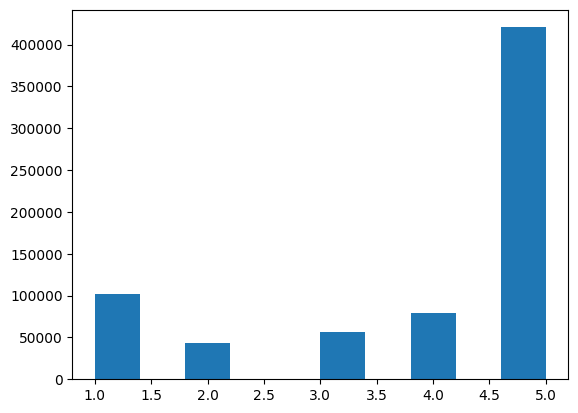

In [12]:
ratings = []
for review in dataset["full"]:
    ratings.append(review['rating'])
plt.hist(ratings)

In [ ]:
# Define a simple Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

# Define a simple Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

# Define the seq2seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
        
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        
        return outputs

# Dataset class
class TitleDataset(Dataset):
    def __init__(self, articles, titles, tokenizer):
        self.articles = articles
        self.titles = titles
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.articles)
    
    def __getitem__(self, idx):
        article = self.articles[idx]
        title = self.titles[idx]
        article_tokens = word_tokenize(article.lower())
        title_tokens = word_tokenize(title.lower())
        article_indexes = [self.tokenizer[word] for word in article_tokens]
        title_indexes = [self.tokenizer[word] for word in title_tokens]
        return {'article': torch.tensor(article_indexes), 'title': torch.tensor(title_indexes)}

# Collate function for padding sequences
def collate_fn(batch):
    articles = [item['article'] for item in batch]
    titles = [item['title'] for item in batch]
    padded_articles = pad_sequence(articles, batch_first=True)
    padded_titles = pad_sequence(titles, batch_first=True)
    return {'article': padded_articles, 'title': padded_titles}

# Assuming you have articles and their titles as lists
articles = [...]  # List of articles
titles = [...]    # Corresponding list of titles

# Tokenization
word2index = {}
index = 0
for article, title in zip(articles, titles):
    for word in word_tokenize(article.lower()):
        if word not in word2index:
            word2index[word] = index
            index += 1
    for word in word_tokenize(title.lower()):
        if word not in word2index:
            word2index[word] = index
            index += 1

# Split data into train and validation sets
articles_train, articles_val, titles_train, titles_val = train_test_split(articles, titles, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = TitleDataset(articles_train, titles_train, word2index)
val_dataset = TitleDataset(articles_val, titles_val, word2index)

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

# Define hyperparameters
INPUT_DIM = len(word2index)
OUTPUT_DIM = len(word2index)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.001
N_EPOCHS = 10

# Initialize model, optimizer, and loss function
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(encoder, decoder, device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Train the model
for epoch in range(N_EPOCHS):
    model.train()
    for batch in train_loader:
        src = batch['article'].to(device)
        trg = batch['title'].to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}, Train Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in val_loader:
        src = batch['article'].to(device)
        trg = batch['title'].to(device)
        output = model(src, trg, 0)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f'Validation Loss: {avg_loss:.4f}')

# Inference
def generate_title(article):
    article_tokens = word_tokenize(article.lower())
    article_indexes = [word2index[word] for word in article_tokens]
    article_tensor = torch.tensor(article_indexes).unsqueeze